# Starbucks Capstone Challenge

## Analyzing Starbucks Offers

In this project, I explore the Starbucks transactions dataset to uncover which offers effectively encourage users to purchase more coffee. 

To do this, I explore a dataset that simulates customer behavior on the Starbucks rewards mobile app. Starbucks regularly sends out offers to app users, typically every few days. There are 3 different offer types: 
- Buy One Get One Free (BOGO),
- Discount , and
- Informational (provides information about products).

Each offer has a specific validity period before it expires. For example, a BOGO offer might be valid for only 5 days. Interestingly, informational offers—designed to provide product details—also come with a validity period. 

Not all users receive the same offers at the same time - this elicits the question of whether there are some offers that are more effective than others for a specific user.

This data set includes user activity such as:

- Timestamps of each purchase
- The amounts spent
- Offer received by users
- When they viewed and completed those offers


### Project Objectives

In this project, I combine transaction data, demographic information, and offer details to determine which demographic groups respond best to different types of offers.


### Example

To illustrate how offers work, consider this scenario: A user receives a discount offer of "buy $10, get $2 off" on a Monday. This offer is valid for 10 days from the date it is received. If the customer accumulates at least $10 in purchases during this validity period, they complete the offer.

However, there are important nuances to note in this dataset. Customers do not actively opt into the offers they receive. For instance, a user might receive the "buy $10, get $2 off" offer but never actually view it during the 10-day validity period. If the customer spends $15 within those ten days, there will still be a record of offer completion in the dataset. Yet, the customer was not influenced by the offer since they never viewed it.

This makes data cleaning particularly crucial and challenging.

It’s also essential to recognize that some demographic groups may make purchases even without receiving an offer. From a business perspective, if a customer is likely to spend $10 without any incentive, it wouldn’t make sense to send them a "buy $10, get $2 off" offer. Therefore, I need to assess what certain demographic groups are likely to purchase when they do not receive any offers.


# Overview of the data sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here are the details pertaining to the variables in each file:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO ( = Buy One Get One), discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Project Roadmap

1) We will firstly explore the datasets to understand the different variables. 

2) We will clean the datasets as appropriate.

3) We will classify effective and ineffective offers.

4) To understand what drives the effectiveness of an offer, we will build a list of features from the data set.

5) We will apply machine learning models to the features and gain an understanding of the essential features and the underlying patterns in the dataset. 

# Import required libraries and datasets

In [1]:
## Import all the required libraries

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [121]:
# read in the different datasets 
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
In this section, we will explore the datasets. We will look for any missing values in the datasets. We will also visualize any relevant data to understand it better. 

## 1. Portfolio Dataset

Let us first look at the portfolio dataset which contains information about the different offers.

In [7]:
portfolio.head() 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


The portfolio dataset contains the following variables:

* id (string) - offer id
* offer_type (string) - the type of offers: BOGO = Buy one get one free, discount, informational offer
* difficulty (int) - minimum amount to be spent to obtain an offer
* reward (int) - reward obtained for selecting an offer
* duration (int) - time for which the offer is open (in days)
* channels (list of strings) - different ways by which the offer is communicated to the customer


Let us next check if there are any missing values in the dataset.

In [10]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


As we can see above, there are 10 entries in the portfolio dataframe and there are no missing values in any of the columns.

## 2. Profile Dataset
Let us now look at the profile dataset, which contains information about the demographics of the customers. 

In [14]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The profile dataset contains the following variables:

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


Let us next check if there are any missing values in the dataset.

In [17]:
profile.info() # To check if there are any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


It looks like there are a few missing values because the Non-Null entry is not the same for all the columns.

In [20]:
profile.isnull().sum() # To see the number of missing values

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

As we can see that there are null values in gender and income column. It turns out that both these columns have null values on the same rows. Therefore we will discard these rows.

In [23]:
profile2 = profile.dropna() # Drop the Null valued rows
profile2.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [25]:
profile2.became_member_on.max() # The last ever date on which someone became a member. We will use this later
# to convert this variable into number of days

20180726

In [27]:
profile2.isnull().sum() # Let's ensure that the null values are removed

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [29]:
profile2.gender.value_counts() # The gender distribution of the dataset

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

<Axes: xlabel='income', ylabel='Count'>

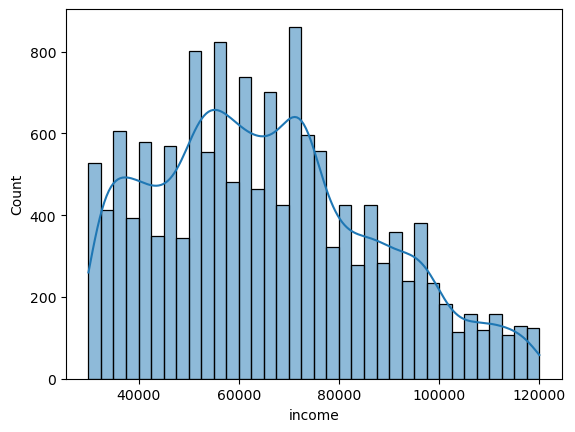

In [31]:
# The income histogram of the dataset
sns.histplot(profile2.income, kde=True)

<Axes: xlabel='age', ylabel='Count'>

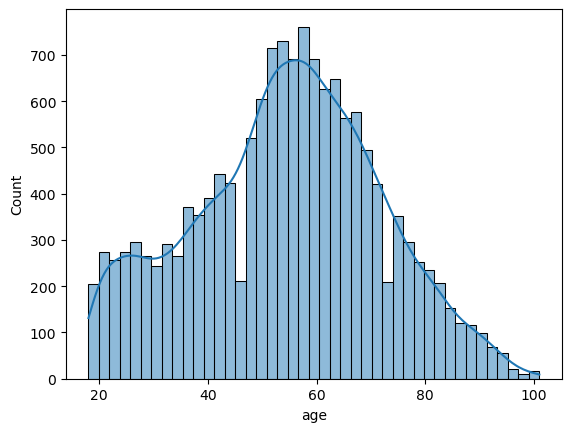

In [32]:
# The age distribution of the dataset
sns.histplot(profile2.age, kde=True)

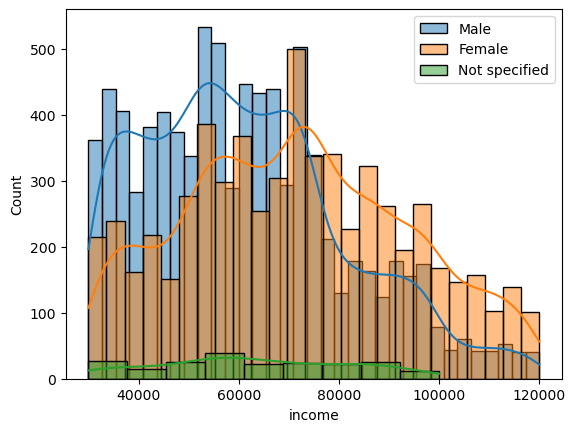

In [34]:
# We can also look at income distribution as classified by the gender specified.
sns.histplot(profile[profile.gender=='M'].income,label='Male', kde=True)
sns.histplot(profile[profile.gender=='F'].income,label='Female', kde=True)
sns.histplot(profile[profile.gender=='O'].income,label='Not specified', kde=True)
plt.legend()
plt.show()

## 3. Transcript dataset

Let us now look at the transcript dataset which stores information about the different events.

In [38]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


The transcript dataset contains the following variables:

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [41]:
# Let is check if there are any missing value
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [43]:
# It seems like there are no missing values.
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [45]:
# The number of events in each category
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

Let us look at the value column in more detail.

In [48]:
# understanding the value column
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

The value column corresponds to different things depending on what the event is. If an offer is received/viewed/completed, the value contain the offer id. If there is a transaction, it contains the amount/reward of the transaction. Let us try to separate these details into different columns.

In [51]:
transcript_vals = transcript['value'].apply(pd.Series)
transcript_vals.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [52]:
# We need to concatenate trans_vals to transcript and then deal with the null values
transcript2 = pd.concat([transcript, transcript_vals], axis=1)
transcript2.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


Now we can drop the values column!

In [54]:
transcript2 = transcript2.drop(columns=['value'])

In [55]:
transcript2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   offer id  134002 non-null  object 
 4   amount    138953 non-null  float64
 5   offer_id  33579 non-null   object 
 6   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB


In [56]:
# create a new column new_offer_id
# if offer_id is null and offer id is not null, then pick the offer id value, else pick the offer_id column value
transcript2['new_offer_id'] = np.where(transcript2['offer_id'].isnull() & transcript2['offer id'].notnull(), transcript2['offer id'], transcript2['offer_id'])

# drop the original offer id columns
transcript2.drop(['offer id', 'offer_id'], axis=1, inplace=True)

transcript2.head()

,person,event,time,amount,reward,new_offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


# Defining effective and ineffective offers


Now that we have looked at the datasets, let us try to classify the offers into effective and ineffective offers. 


**1. Effective offers: the offers which are received, viewed and result in a transcation**

    - offer received -> offer viewed -> transaction -> offer completed (BOGO/discount offers)
    - offer received -> offer viewed -> transaction (informational offers)

**2. Ineffective offers: the offers that were received and viewed but no action further taken**

    - offer received -> offer viewed

There are other categories as well, where people may have taken the offer even without viewing the offer or ones where people have not viewed the offer at all. We are not concerned with these cases because we want to study what makes an offer effective when it is viewed.

In [58]:
# Let us sort the events in the transcript dataset by person and then by time
transcript_sorted = transcript2.sort_values(['person','time'])
transcript_sorted.head()

,person,event,time,amount,reward,new_offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed


As we can see above, the rows of transcript_sorted is sorted by person id and then by the actions they take in time. It seems like the offer_id for the transcactions is missing, let's check if this is generally the case.

In [60]:
transcript_sorted[transcript_sorted['event'] == 'transaction'] # Looking specifically at the transactions

,person,event,time,amount,reward,new_offer_id
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN
168412,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,NaN
228422,0009655768c64bdeb2e877511632db8f,transaction,528,14.11,NaN,NaN
237784,0009655768c64bdeb2e877511632db8f,transaction,552,13.56,NaN,NaN
258883,0009655768c64bdeb2e877511632db8f,transaction,576,10.27,NaN,NaN
...,...,...,...,...,...,...
200255,ffff82501cea40309d5fdd7edcca4a07,transaction,498,13.17,NaN,NaN
214716,ffff82501cea40309d5fdd7edcca4a07,transaction,504,7.79,NaN,NaN
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14.23,NaN,NaN
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10.12,NaN,NaN


It seems indeed that the new_offer_id column is always NaN for the transaction event. Let us fill it in with the offer_id of the previous offer_received or offer_viewed.

In [62]:
# we want to fill in the offer_ids for the transactions: this can be done using ffill()
transcript_sorted.update(transcript_sorted.groupby(['person']).ffill())
transcript_sorted.head()

,person,event,time,amount,reward,new_offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837
113605,0009655768c64bdeb2e877511632db8f,offer received,336,22.16,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,22.16,NaN,3f207df678b143eea3cee63160fa8bed


# Defining an effective offer completed column

We will add a new column correposnding to whether an effective offer was completed. To do this, we will use only the trascript rows that correspond to offers that are viewed. If the offer is viewed and there is a transaction, we will set the offer_completed to 1. If the offer is viewed but there is no immediate transaction, we will set the offer_completed to 0. Note that we are not taking the added complication of whether the transaction was made within the duration of the offer. If a transaction was made, we consider the offer effective irrespective of the time when it was completed.

In [117]:
# Let us now create an offer completed column. This column will be equal to 1 if the offer viewed comes before 
# transcation for the corresponding offer viewed event. Let us begin by initializing this with 0.

transcript_sorted['offer completed'] = 0 # define a new column called offer completed; we will update this soon!
transcript_sorted.loc[transcript_sorted.event =='transaction','offer completed'] = 1 # Whenever there is a 
# transaction, we temporarily set it to 1. However, it must be kept in mind that sometimes the transaction could be completed
# without having viewed the offer. We should set the offer_completed for such rows to be 0 instead.

# To do this, compute the diff.
print(transcript_sorted['offer completed'][0:-1])
transcript_sorted['offer completed'][0:-1] = np.diff(transcript_sorted['offer completed'])
# whereever offer completed =1, it means that it just preceded a trasaction. 
# If this corresponds to an offer viewed, then the offer is effective. Else the offer is not effective

# Set all the other elements of the column to be 0. This way, only the offer viewed which preceeded a transaction 
# immediately have the value of 1.
transcript_sorted.loc[transcript_sorted.event !='offer viewed','offer completed'] = 0

# Select only the offer viewed rows. 
transcript_viewed = transcript_sorted[transcript_sorted.event =='offer viewed']
transcript_viewed.head()# This gives a list of viewed offers which are effective and which are not

55972     0
77705     0
89291     1
113605    0
139992    0
         ..
246495    0
258361    1
258362    0
262475    0
274809    1
Name: offer completed, Length: 306533, dtype: int64


/var/folders/hh/8yw3l0vd7tl_nwj91tn4ftnm0000gn/T/ipykernel_43276/3439923234.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  transcript_sorted['offer completed'][0:-1] = np.diff(transcript_sorted['offer completed'])
/var/folders/hh/8yw3l

,person,event,time,amount,reward,new_offer_id,offer completed
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,1
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,22.16,NaN,3f207df678b143eea3cee63160fa8bed,0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,8.57,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0
233413,0009655768c64bdeb2e877511632db8f,offer viewed,540,14.11,2.0,fafdcd668e3743c1bb461111dcafc2a4,1
85769,00116118485d4dfda04fdbaba9a87b5c,offer viewed,216,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,1


In [123]:
# Merge portfolio dataset to get offer data
portfolio.rename(columns={'id':'new_offer_id'},inplace=True)
transcript_sorted2 = transcript_sorted.merge(portfolio, how = 'left',on='new_offer_id')

profile2.rename(columns={'id':'person'},inplace=True)
transcript_sorted3 = transcript_sorted2.merge(profile2, how = 'left',on='person')
transcript_sorted3.head()

,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0.0,"[email, mobile, social]",0.0,3.0,informational,M,33.0,20170421.0,72000.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,1,0.0,"[email, mobile, social]",0.0,3.0,informational,M,33.0,20170421.0,72000.0
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0.0,"[email, mobile, social]",0.0,3.0,informational,M,33.0,20170421.0,72000.0
3,0009655768c64bdeb2e877511632db8f,offer received,336,22.16,NaN,3f207df678b143eea3cee63160fa8bed,0,0.0,"[web, email, mobile]",0.0,4.0,informational,M,33.0,20170421.0,72000.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,22.16,NaN,3f207df678b143eea3cee63160fa8bed,0,0.0,"[web, email, mobile]",0.0,4.0,informational,M,33.0,20170421.0,72000.0


In [125]:
transcript_viewed2 = transcript_sorted3[transcript_sorted3.event =='offer viewed']
transcript_viewed2 = transcript_viewed2.dropna()
transcript_viewed2.head()# This gives a list of viewed offers which are effective and which are not.

# We will not worry about the validity period because even if the validiy period had passed, viewing the offer
# would have had an effect on the user making the transaction!


,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,8.57,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,M,33.0,20170421.0,72000.0
12,0009655768c64bdeb2e877511632db8f,offer viewed,540,14.11,2.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,"[web, email, mobile, social]",10.0,10.0,discount,M,33.0,20170421.0,72000.0
35,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,11.93,3.0,5a8bc65990b245e5a138643cd4eb9837,0,0.0,"[email, mobile, social]",0.0,3.0,informational,O,40.0,20180109.0,57000.0
37,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,432,11.93,3.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,5.0,"[web, email]",20.0,10.0,discount,O,40.0,20180109.0,57000.0
39,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,516,11.93,3.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5.0,"[web, email, mobile]",5.0,7.0,bogo,O,40.0,20180109.0,57000.0


Now, we will convert the became_member_on into number_of_member_days. The last member joined on 26/07/2018. To obtain the number_of_member_days, we will subtract the became_member_on date from the date just after this date i.e. 27/07/2018 and convert it to number of days.

In [127]:
#Now we will convert became_member_on into member tenure
transcript_viewed2['year'] = pd.Series([int(str(x)[0:4]) for x in transcript_viewed2['became_member_on']], index = transcript_viewed2.index)
transcript_viewed2['month'] = pd.Series([int(str(x)[4:6]) for x in transcript_viewed2['became_member_on']], index = transcript_viewed2.index)
transcript_viewed2['day']=pd.Series([int(str(x)[6:8]) for x in transcript_viewed2['became_member_on']], index = transcript_viewed2.index)
transcript_viewed2 = transcript_viewed2.drop('became_member_on', axis=1, inplace=False)
transcript_viewed2.loc[transcript_viewed2['year'] == 2018, 'number_of_member_days'] = (31*transcript_viewed2['month'])+transcript_viewed2['day'] # 31 is a bit approximate for the number of days in a month
transcript_viewed2.loc[transcript_viewed2['year'] != 2018, 'number_of_member_days'] = ((2018 - transcript_viewed2['year'] )*365)+(31*(7 -transcript_viewed2['month']))+(27 - transcript_viewed2['day'])
transcript_viewed2 = transcript_viewed2.drop(['year','month','day'], axis=1, inplace=False)

transcript_viewed2.head()

,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,channels,difficulty,duration,offer_type,gender,age,income,number_of_member_days
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,8.57,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,"[web, email, mobile, social]",5.0,5.0,bogo,M,33.0,72000.0,464.0
12,0009655768c64bdeb2e877511632db8f,offer viewed,540,14.11,2.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,"[web, email, mobile, social]",10.0,10.0,discount,M,33.0,72000.0,464.0
35,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,354,11.93,3.0,5a8bc65990b245e5a138643cd4eb9837,0,0.0,"[email, mobile, social]",0.0,3.0,informational,O,40.0,57000.0,40.0
37,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,432,11.93,3.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,5.0,"[web, email]",20.0,10.0,discount,O,40.0,57000.0,40.0
39,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,516,11.93,3.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5.0,"[web, email, mobile]",5.0,7.0,bogo,O,40.0,57000.0,40.0


In [129]:
# Now, let us convert channels and gender into categorical variables. 
for index, row in transcript_viewed2.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in transcript_viewed2.loc[index, 'channels']:
            transcript_viewed2.loc[index, channel] = 1
        else:
            transcript_viewed2.loc[index, channel] = 0
transcript_viewed2 = transcript_viewed2.drop(['channels'], axis=1, inplace=False)


# Let us convert gender into categorical variables

transcript_viewed2 = transcript_viewed2[transcript_viewed2.gender != 'O']

for index, row in transcript_viewed2.iterrows():
    for gender_var in ['M', 'F']:
        if gender_var in transcript_viewed2.loc[index, 'gender']:
            transcript_viewed2.loc[index, gender_var] = 1
        else:
            transcript_viewed2.loc[index, gender_var] = 0
transcript_viewed2 = transcript_viewed2.drop(['gender'], axis=1, inplace=False)
transcript_viewed2.head()

,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,difficulty,duration,offer_type,age,income,number_of_member_days,web,email,social,mobile,M,F
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,8.57,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,5.0,5.0,bogo,33.0,72000.0,464.0,1.0,1.0,1.0,1.0,1.0,0.0
12,0009655768c64bdeb2e877511632db8f,offer viewed,540,14.11,2.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,10.0,10.0,discount,33.0,72000.0,464.0,1.0,1.0,1.0,1.0,1.0,0.0
55,0020c2b971eb4e9188eac86d93036a77,offer viewed,426,24.31,2.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,10.0,5.0,bogo,59.0,90000.0,877.0,1.0,1.0,1.0,1.0,0.0,1.0
61,0020c2b971eb4e9188eac86d93036a77,offer viewed,660,33.86,10.0,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0.0,3.0,informational,59.0,90000.0,877.0,0.0,1.0,1.0,1.0,0.0,1.0
73,0020ccbbb6d84e358d3414a3ff76cffd,offer viewed,348,14.27,3.0,f19421c1d4aa40978ebb69ca19b0e20d,1,5.0,5.0,5.0,bogo,24.0,60000.0,622.0,1.0,1.0,1.0,1.0,0.0,1.0


In [130]:
#split transcript into 3 different offer types
bogo = transcript_viewed2[transcript_viewed2['offer_type']=='bogo'].copy()
discount = transcript_viewed2[transcript_viewed2['offer_type']=='discount'].copy()
informational = transcript_viewed2[transcript_viewed2['offer_type']=='informational'].copy()

In [131]:
bogo.head() # the buy one, get one offers dataframe

,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,difficulty,duration,offer_type,age,income,number_of_member_days,web,email,social,mobile,M,F
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,8.57,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,5.0,5.0,bogo,33.0,72000.0,464.0,1.0,1.0,1.0,1.0,1.0,0.0
55,0020c2b971eb4e9188eac86d93036a77,offer viewed,426,24.31,2.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10.0,10.0,5.0,bogo,59.0,90000.0,877.0,1.0,1.0,1.0,1.0,0.0,1.0
73,0020ccbbb6d84e358d3414a3ff76cffd,offer viewed,348,14.27,3.0,f19421c1d4aa40978ebb69ca19b0e20d,1,5.0,5.0,5.0,bogo,24.0,60000.0,622.0,1.0,1.0,1.0,1.0,0.0,1.0
83,0020ccbbb6d84e358d3414a3ff76cffd,offer viewed,582,19.10,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5.0,5.0,7.0,bogo,24.0,60000.0,622.0,1.0,1.0,0.0,1.0,0.0,1.0
166,004c5799adbf42868b9cff0396190900,offer viewed,408,35.14,10.0,f19421c1d4aa40978ebb69ca19b0e20d,1,5.0,5.0,5.0,bogo,54.0,99000.0,850.0,1.0,1.0,1.0,1.0,1.0,0.0


In [132]:
discount.head() # the discount offers dataframe

,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,difficulty,duration,offer_type,age,income,number_of_member_days,web,email,social,mobile,M,F
12,0009655768c64bdeb2e877511632db8f,offer viewed,540,14.11,2.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,10.0,10.0,discount,33.0,72000.0,464.0,1.0,1.0,1.0,1.0,1.0,0.0
103,003d66b6608740288d6cc97a6903f4f0,offer viewed,420,5.94,2.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,10.0,10.0,discount,26.0,73000.0,402.0,1.0,1.0,1.0,1.0,0.0,1.0
152,004b041fbfe44859945daa2c7f79ee64,offer viewed,576,27.92,5.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,10.0,10.0,discount,55.0,74000.0,163.0,1.0,1.0,1.0,1.0,0.0,1.0
178,004c5799adbf42868b9cff0396190900,offer viewed,648,22.22,2.0,fafdcd668e3743c1bb461111dcafc2a4,1,2.0,10.0,10.0,discount,54.0,99000.0,850.0,1.0,1.0,1.0,1.0,1.0,0.0
207,0056df74b63b4298809f0b375a304cf4,offer viewed,654,29.77,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3.0,7.0,7.0,discount,54.0,91000.0,705.0,1.0,1.0,1.0,1.0,1.0,0.0


In [133]:
informational.head() # the informational offers dataframe

,person,event,time,amount,reward_x,new_offer_id,offer completed,reward_y,difficulty,duration,offer_type,age,income,number_of_member_days,web,email,social,mobile,M,F
61,0020c2b971eb4e9188eac86d93036a77,offer viewed,660,33.86,10.0,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0.0,3.0,informational,59.0,90000.0,877.0,0.0,1.0,1.0,1.0,0.0,1.0
77,0020ccbbb6d84e358d3414a3ff76cffd,offer viewed,408,14.53,5.0,5a8bc65990b245e5a138643cd4eb9837,1,0.0,0.0,3.0,informational,24.0,60000.0,622.0,0.0,1.0,1.0,1.0,0.0,1.0
202,0056df74b63b4298809f0b375a304cf4,offer viewed,528,27.59,5.0,3f207df678b143eea3cee63160fa8bed,1,0.0,0.0,4.0,informational,54.0,91000.0,705.0,1.0,1.0,0.0,1.0,1.0,0.0
278,0082fd87c18f45f2be70dbcbb0fb8aad,offer viewed,636,20.74,5.0,3f207df678b143eea3cee63160fa8bed,1,0.0,0.0,4.0,informational,28.0,68000.0,322.0,1.0,1.0,0.0,1.0,0.0,1.0
499,00b18b535d6d4f779dea4dc9ac451478,offer viewed,420,23.97,3.0,5a8bc65990b245e5a138643cd4eb9837,0,0.0,0.0,3.0,informational,72.0,102000.0,478.0,0.0,1.0,1.0,1.0,1.0,0.0


Now that we have subset all our datasets into effective and ineffective offers depending on offer type, we can append the datasets accordingly into datasets for modeling. Before we begin the ML models however, let us see if there is any demogrpahics that correspond more to the effective offers. We can specifically look at age, gender and income.

# Demographics corresponding to effective offers

## Age

Let us first look at the age distributions for effective and ineffective offers in case of all the three offers.

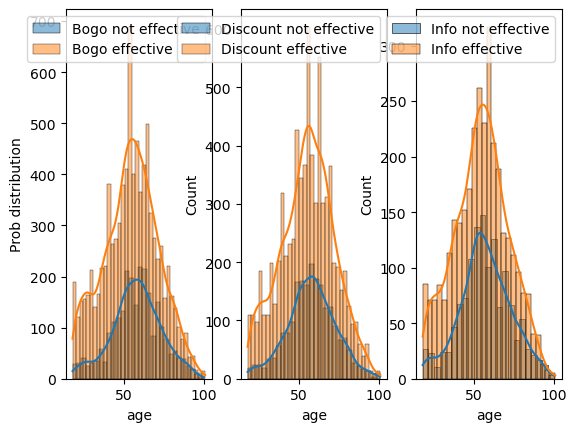

In [136]:
# using tuple unpacking for multiple Axes

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = (20, 6)
sns.histplot(bogo[bogo['offer completed']==0].age,label='Bogo not effective', ax = ax1, kde=True)
sns.histplot(bogo[bogo['offer completed']==1].age,label='Bogo effective', ax = ax1, kde=True)
ax1.set_ylabel('Prob distribution')
ax1.legend()
sns.histplot(discount[discount['offer completed']==0].age,label='Discount not effective', ax = ax2, kde=True)
sns.histplot(discount[discount['offer completed']==1].age,label='Discount effective', ax = ax2, kde=True)
ax2.legend()
sns.histplot(informational[informational['offer completed']==0].age,label='Info not effective', ax = ax3, kde=True)
sns.histplot(informational[informational['offer completed']==1].age,label='Info effective', ax = ax3, kde=True)
ax3.legend()
plt.show()

Interestingly enough, the offers seem to be slightly more effective for the younger age group (20-40 years) and lesser effective for the mid age group (40-60 years) in all the three cases. However, it should be noted that the distributions also show that most of the customers on the app are in the range 40-70 years.

## Income

Let us first look at the income distributions for effective and ineffective offers.

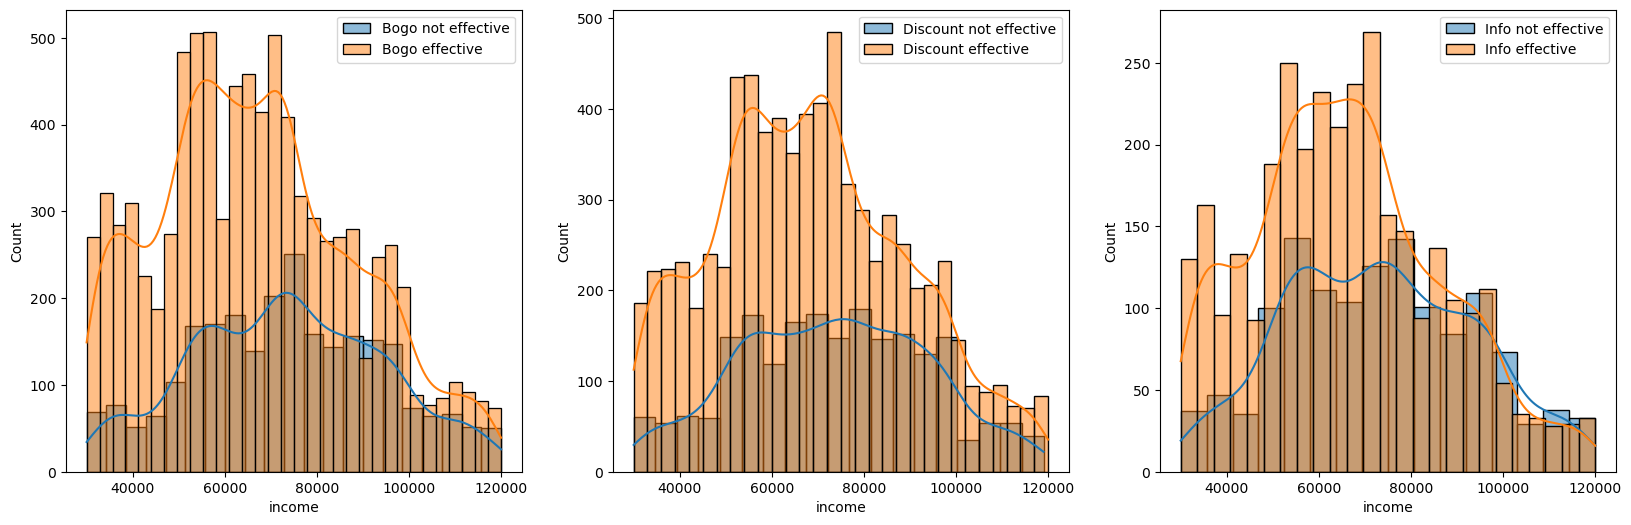

In [139]:
# using tuple unpacking for multiple Axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = (20, 6)
sns.histplot(bogo[bogo['offer completed']==0].income,label='Bogo not effective', ax = ax1, kde=True)
sns.histplot(bogo[bogo['offer completed']==1].income,label='Bogo effective', ax = ax1, kde=True)
ax1.legend()
sns.histplot(discount[discount['offer completed']==0].income,label='Discount not effective', ax = ax2, kde=True)
sns.histplot(discount[discount['offer completed']==1].income,label='Discount effective', ax = ax2, kde=True)
ax2.legend()
sns.histplot(informational[informational['offer completed']==0].income,label='Info not effective', ax = ax3, kde=True)
sns.histplot(informational[informational['offer completed']==1].income,label='Info effective', ax = ax3, kde=True)
ax3.legend()
plt.show()

Surprisingly enough, the offers seem to be slightly more effective for lower income groups in all the three cases. I would have naively thought that the more you have, the more you spend on the offers. However, this does not seem to be the case.

## Gender

Let us first look at the gender distributions for effective and ineffective offers.

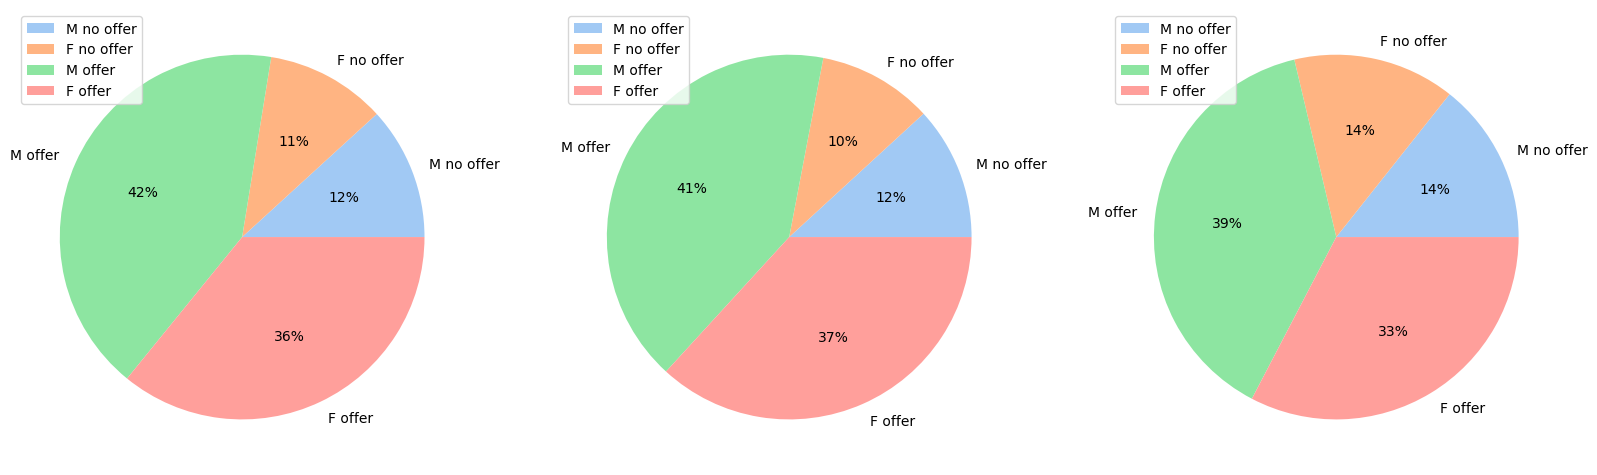

In [142]:
# using tuple unpacking for multiple Axes

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:4]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = (20, 6)

data_bogo = [bogo[bogo['offer completed']==0].M.sum(), bogo[bogo['offer completed']==0].F.sum(), \
         bogo[bogo['offer completed']==1].M.sum(), bogo[bogo['offer completed']==1].F.sum()]
data_discount = [discount[discount['offer completed']==0].M.sum(), discount[discount['offer completed']==0].F.sum(), \
         discount[discount['offer completed']==1].M.sum(), discount[discount['offer completed']==1].F.sum()]
data_info = [informational[informational['offer completed']==0].M.sum(), informational[informational['offer completed']==0].F.sum(), \
         informational[informational['offer completed']==1].M.sum(), informational[informational['offer completed']==1].F.sum()]
labels = ['M no offer', 'F no offer', 'M offer', 'F offer']


#create pie chart
ax1.pie(data_bogo, labels = labels, colors = colors, autopct='%.0f%%')
ax2.pie(data_discount, labels = labels, colors = colors, autopct='%.0f%%')
ax3.pie(data_info, labels = labels, colors = colors, autopct='%.0f%%')
ax1.legend(loc = 2)
ax2.legend(loc = 2)
ax3.legend(loc = 2)
plt.show()

Overall, the offers seem to be slightly more effective on men than women though. However, this does not seem to be a very strong effect.

# Creating the ML pipeline

Now, we now want to deploy ML models on our datasets to understand which features are important for effective offers. Our target variable would be "offer completed" and we will use the other columns as features (where possible). We will try to predict whether the offer was completed or not from the other features.

We will firstly build a general ML pipeline that we can use with any specific ML model (decision tree or random forest).

#### Metrics used

To compute the effectiveness of the predictions of the models, we will use two metrics: accuracy, weighted f1-score.

1) Accuracy is the ratio of how correctly we predict whether an offer will be accepted or not to the total number of offers.

2) Weighted F1 scores are lower than accuracy measures as they balances precision and recall on the positive class while accuracy looks at correctly classified observations both positive and negative. That makes a big difference for the imbalanced problems where by default our model will be good at predicting true negatives and hence accuracy will be high. So they are usually a better measure of the model's performance. 



In [151]:
def model_pipeline(model, df, drop_col):
    '''
    input:
        - df: the input datafame ; 
        - drop_col: any columns to be dropped
    
    output:
        - classification results on the train and test dataset
    '''
    
    # Drop the columns and create features and target dataframes
    
    target = list(df['offer completed']) # the target dataframe is the offer completed
    features = df.drop(columns = drop_col,inplace=False,axis=1)
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    # fit and transform scaling on training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # scale test data
    X_test = scaler.transform(X_test)
    
    
    # Fit the model on the training set
    model = model.fit(X_train, y_train)
    
    # Find the predictions on the train and test datasets
    
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
        
    # the output results variable
    results = {}
    results['cols_to_use'] = features.columns
    # compute the training accuracy and the testing accuracy
    results['train_acc']=model.score(X_train,y_train)
    results['test_acc']=model.score(X_test,y_test)
    results['train_mse'] = mean_squared_error(y_train,predictions_train) 
    results['test_mse'] = mean_squared_error(y_test,predictions_test) 
    
    # print the different results
    print("Train accuracy:%.3f" % results['train_acc'])
    print("Test accuracy:%.3f" % results['test_acc'])
    print("MSE_train: %.3f" % results['train_mse'])
    print("MSE_test: %.3f" % results['test_mse'])
    print(classification_report(y_test, predictions_test,digits=4))
    
    return results

# Running the ML models on the BOGO dataset

Now that we have defined the model pipelines, let us find the relevant columns to use as features and fit our ML models. Since there are 3 offer types: BOGO, discount and informational, we will deal with them separately.

In [154]:
bogo.columns

Index(['person', 'event', 'time', 'amount', 'reward_x', 'new_offer_id',
       'offer completed', 'reward_y', 'difficulty', 'duration', 'offer_type',
       'age', 'income', 'number_of_member_days', 'web', 'email', 'social',
       'mobile', 'M', 'F'],
      dtype='object')

Train accuracy:0.785
Test accuracy:0.773
MSE_train: 0.215
MSE_test: 0.227
              precision    recall  f1-score   support

           0     0.5503    0.1553    0.2422       528
           1     0.7888    0.9613    0.8666      1733

    accuracy                         0.7731      2261
   macro avg     0.6696    0.5583    0.5544      2261
weighted avg     0.7331    0.7731    0.7208      2261



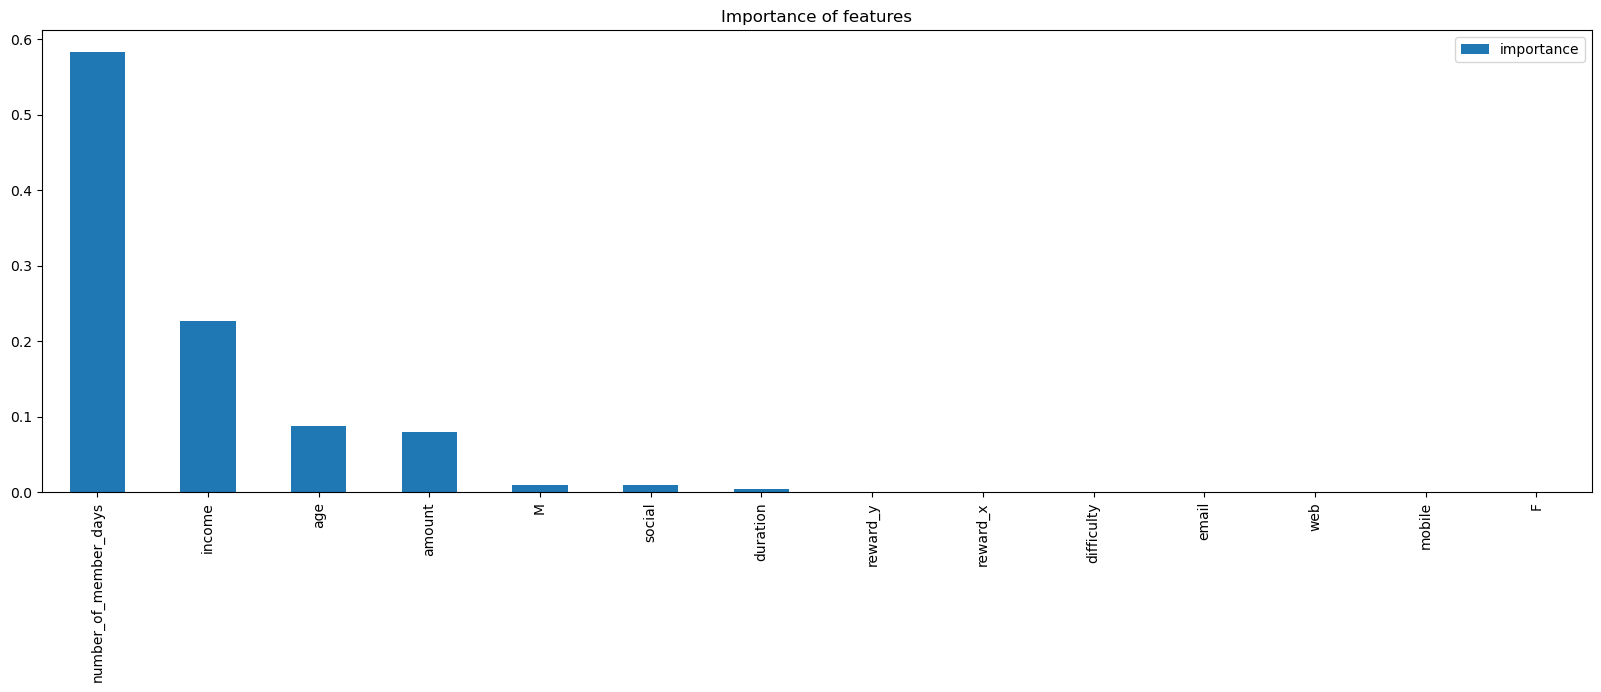

In [156]:
drop_col = ['person','new_offer_id','offer_type', 'event', 'offer completed', 'time'] # These are the columns
# we would like to drop from the features set

#Initialize the decision tree model
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state = 1, min_samples_split = 90, min_samples_leaf = 50)

# Compute the results by fitting the data on the model pipeline for the decision tree model 
results_dt = model_pipeline(decision_tree_model, bogo, drop_col)


# Find out which features are important
feature_importances = pd.DataFrame(decision_tree_model.feature_importances_,
                                   index = results_dt['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Importance of features')
plt.show()

Train accuracy:0.789
Test accuracy:0.771
MSE_train: 0.211
MSE_test: 0.229
              precision    recall  f1-score   support

           0     0.6038    0.0606    0.1102       528
           1     0.7754    0.9879    0.8688      1733

    accuracy                         0.7713      2261
   macro avg     0.6896    0.5242    0.4895      2261
weighted avg     0.7353    0.7713    0.6916      2261



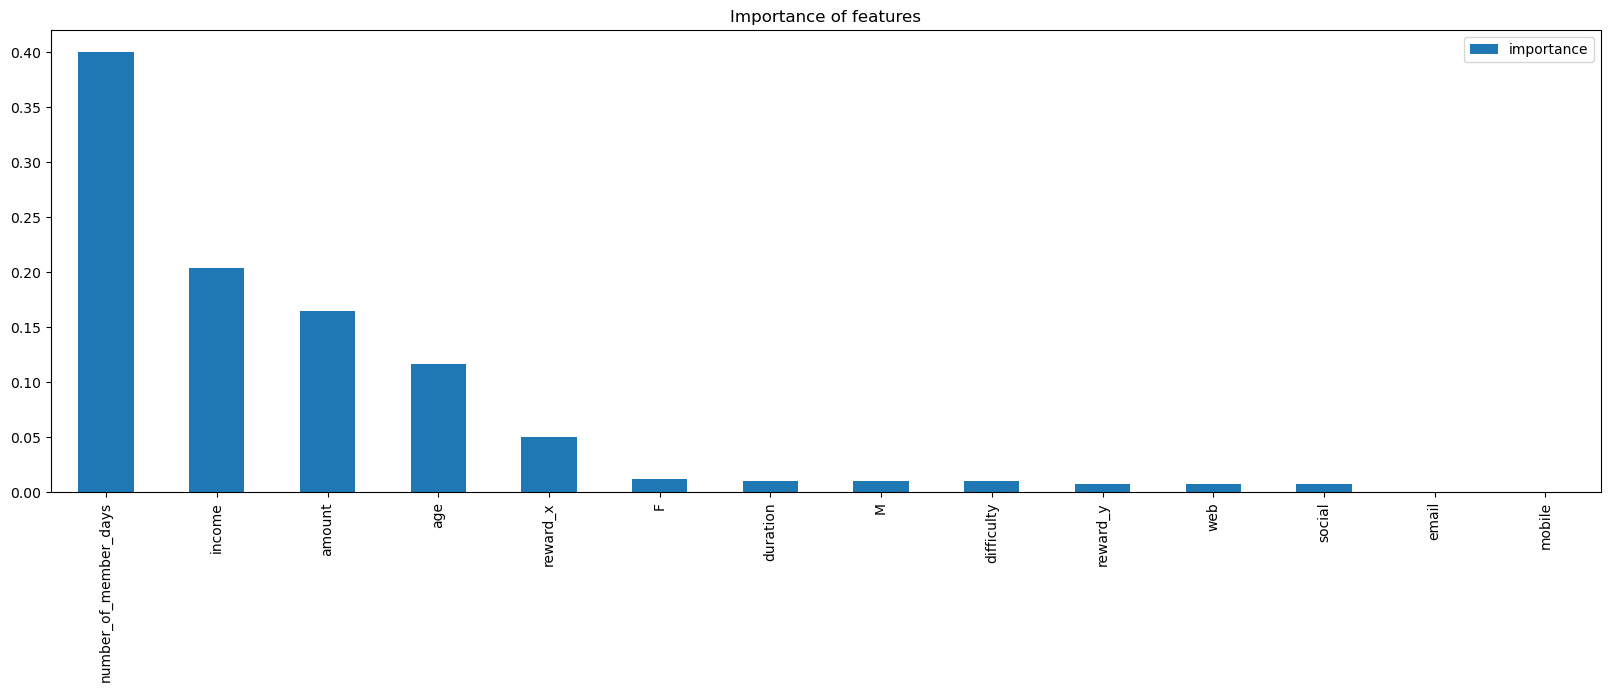

In [158]:
# Initialize the random forest model
rf_model = RandomForestClassifier(random_state = 1, max_depth = 11, max_features= 'sqrt', min_samples_split = 10, n_estimators = 20, min_samples_leaf = 20)

# Compute the results by fitting the data on the model pipeline for the random forest model 
results_rf = model_pipeline(rf_model, bogo, drop_col)


# Find out which features are important
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = results_rf['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Importance of features')
plt.show()

# Running the ML models on the discount dataset

We will now run the ML models on the discount dataset

Train accuracy:0.791
Test accuracy:0.787
MSE_train: 0.209
MSE_test: 0.213
              precision    recall  f1-score   support

           0     0.5417    0.1866    0.2776       418
           1     0.8073    0.9557    0.8752      1490

    accuracy                         0.7872      1908
   macro avg     0.6745    0.5712    0.5764      1908
weighted avg     0.7491    0.7872    0.7443      1908



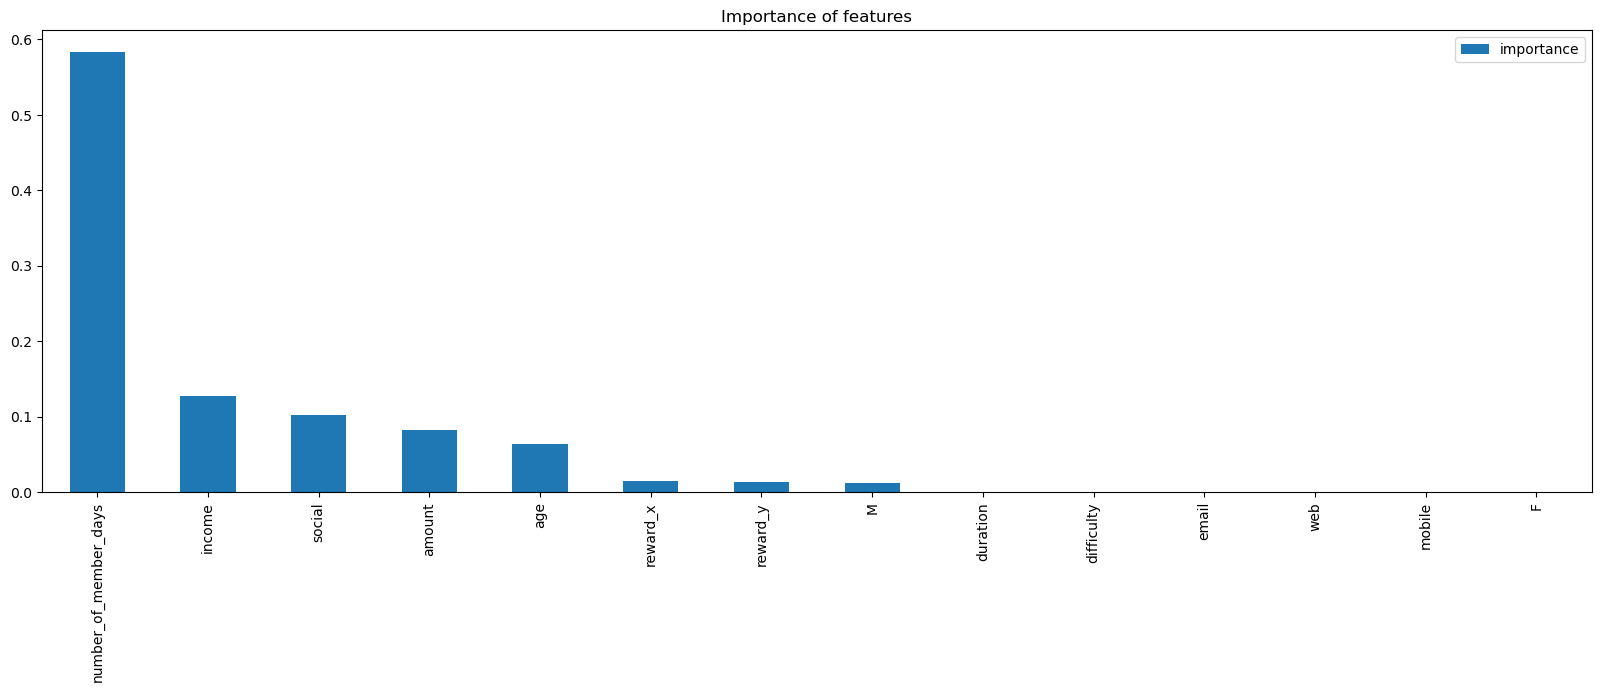

In [161]:
drop_col = ['person','new_offer_id','offer_type', 'event', 'offer completed', 'time'] # These are the columns
# we would like to drop from the features set

#Initialize the decision tree model
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state = 1, min_samples_split = 90, min_samples_leaf = 50)

# Compute the results by fitting the data on the model pipeline for the decision tree model 
results_dt = model_pipeline(decision_tree_model, discount, drop_col)


# Find out which features are important
feature_importances = pd.DataFrame(decision_tree_model.feature_importances_,
                                   index = results_dt['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Importance of features')
plt.show()

Train accuracy:0.796
Test accuracy:0.781
MSE_train: 0.204
MSE_test: 0.219
              precision    recall  f1-score   support

           0     0.5000    0.0550    0.0991       418
           1     0.7879    0.9846    0.8753      1490

    accuracy                         0.7809      1908
   macro avg     0.6439    0.5198    0.4872      1908
weighted avg     0.7248    0.7809    0.7053      1908



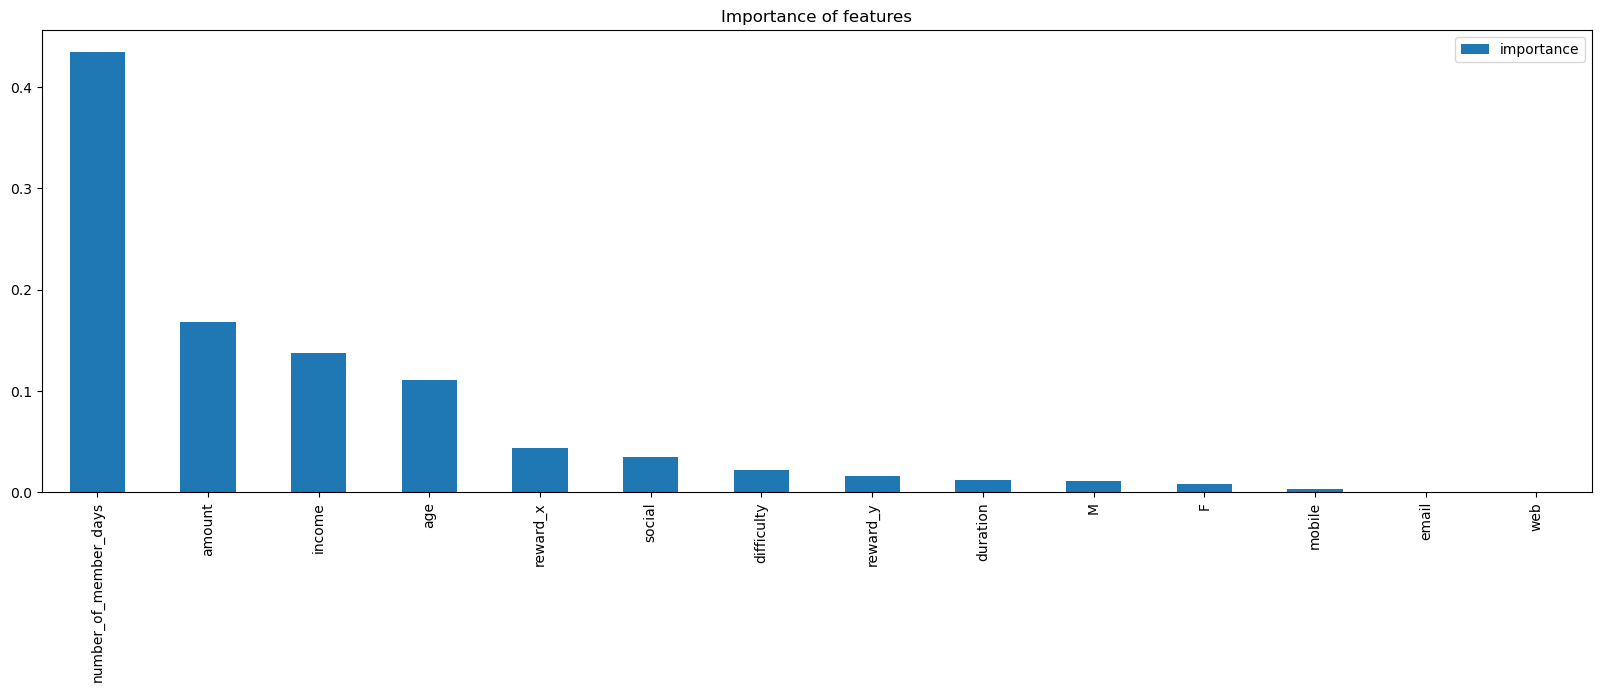

In [163]:
# Initialize the random forest model
rf_model = RandomForestClassifier(random_state = 1, max_depth = 11, max_features= 'sqrt', min_samples_split = 10, n_estimators = 20, min_samples_leaf = 20)

# Compute the results by fitting the data on the model pipeline for the random forest model 
results_rf = model_pipeline(rf_model, discount, drop_col)


# Find out which features are important
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = results_rf['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Importance of features')
plt.show()

# Running the ML models on the informational dataset

We will now run the ML models on the informational dataset

Train accuracy:0.730
Test accuracy:0.693
MSE_train: 0.270
MSE_test: 0.307
              precision    recall  f1-score   support

           0     0.4824    0.1475    0.2259       278
           1     0.7145    0.9309    0.8085       637

    accuracy                         0.6929       915
   macro avg     0.5984    0.5392    0.5172       915
weighted avg     0.6439    0.6929    0.6315       915



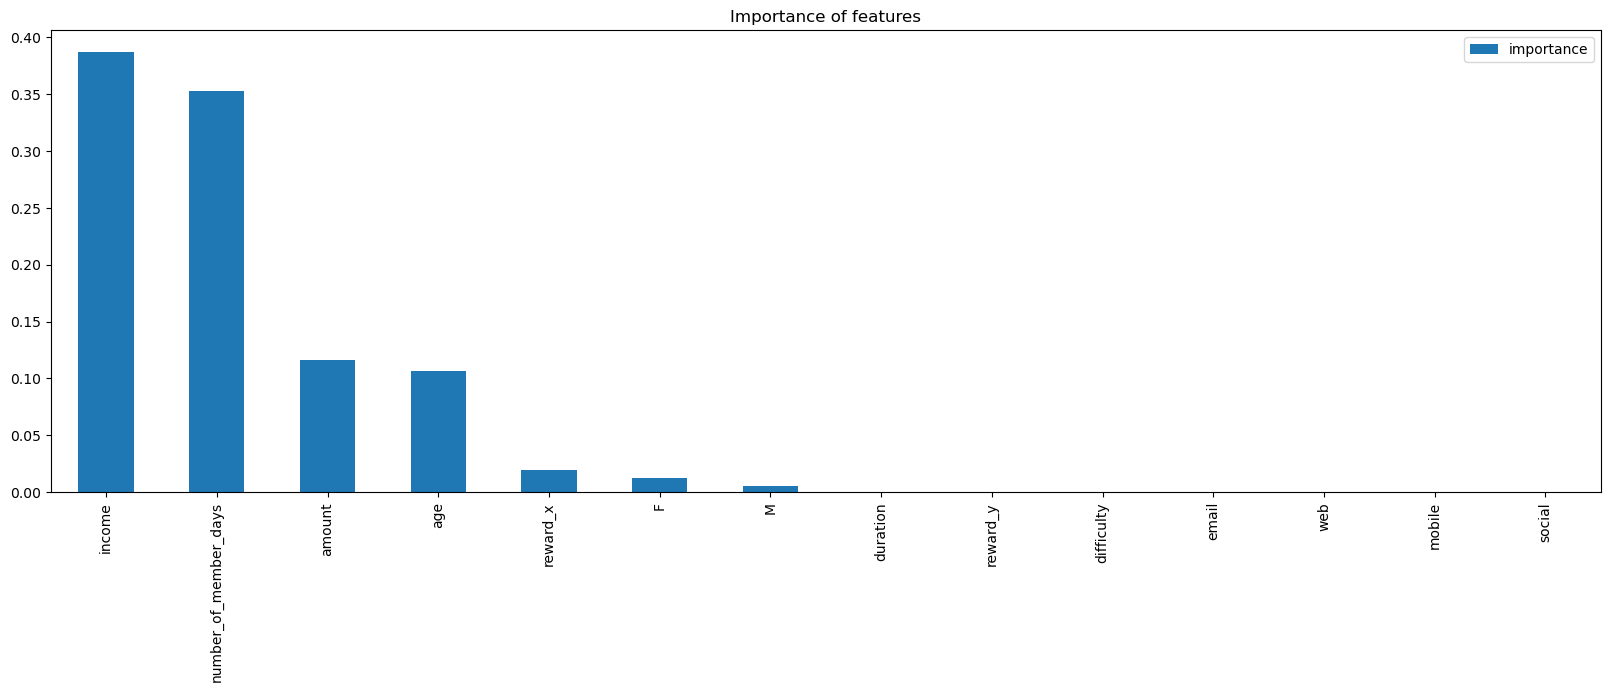

In [166]:
drop_col = ['person','new_offer_id','offer_type', 'event', 'offer completed', 'time'] # These are the columns
# we would like to drop from the features set

#Initialize the decision tree model
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state = 1, min_samples_split = 90, min_samples_leaf = 50)

# Compute the results by fitting the data on the model pipeline for the decision tree model 
results_dt = model_pipeline(decision_tree_model, informational, drop_col)


# Find out which features are important
feature_importances = pd.DataFrame(decision_tree_model.feature_importances_,
                                   index = results_dt['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Importance of features')
plt.show()

Train accuracy:0.731
Test accuracy:0.696
MSE_train: 0.269
MSE_test: 0.304
              precision    recall  f1-score   support

           0     0.5000    0.0396    0.0733       278
           1     0.7010    0.9827    0.8183       637

    accuracy                         0.6962       915
   macro avg     0.6005    0.5111    0.4458       915
weighted avg     0.6399    0.6962    0.5920       915



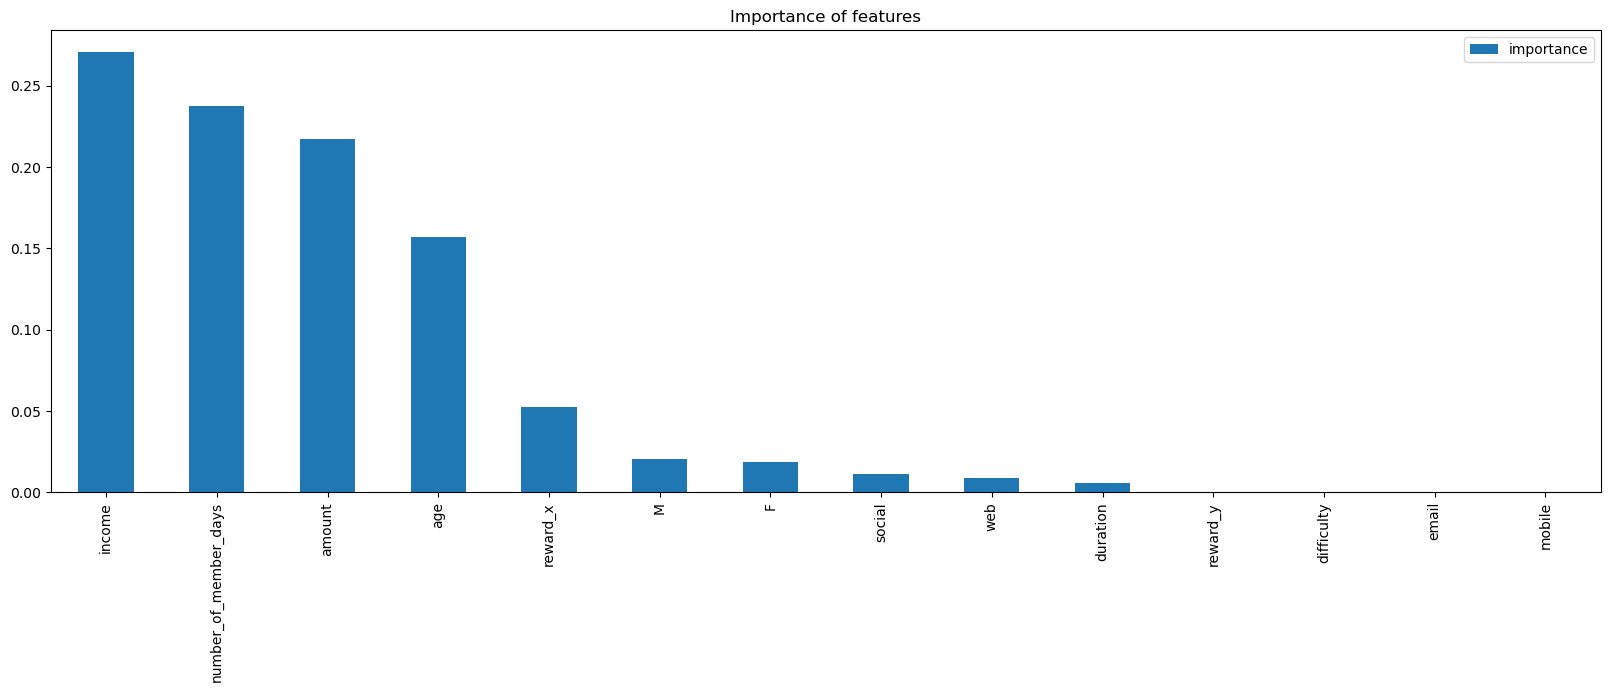

In [168]:
# Initialize the random forest model
rf_model = RandomForestClassifier(random_state = 1, max_depth = 10, max_features= 'sqrt', min_samples_split = 12, n_estimators = 20, min_samples_leaf = 20)

# Compute the results by fitting the data on the model pipeline for the random forest model 
results_rf = model_pipeline(rf_model, informational, drop_col)


# Find out which features are important
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = results_rf['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Importance of features')
plt.show()

# Hyperparameter optimization of random forest models using grid search

In [171]:
# define the Grid Search for random forest model
def grid_search_opt(df, drop_col):
    '''
    input:
        - df: the input datafame ; 
        - drop_col: any columns to be dropped
    
    output:
        - dictionary with best parameters for random forest model
    '''
    
    # Drop the columns and create features and target dataframes
    
    target = list(df['offer completed']) # the target dataframe is the offer completed
    features = df.drop(columns = drop_col,inplace=False,axis=1)
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    # fit and transform scaling on training data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)


    parameter_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5, 10, 15, 20, 25],
                'n_estimators': [25, 30, 35, 40, 45],
                'min_samples_split': [2, 8, 12, 16, 20],
                'min_samples_leaf': [2, 8, 12, 16, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=1), parameter_grid)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_
    return grid_search.best_params_

## Optimized BOGO ML model

In [174]:
drop_col = ['person','new_offer_id','offer_type', 'event', 'offer completed', 'time'] # These are the columns
# we would like to drop from the features set

# run Grid Search : this step takes quite some time to implement. You could comment it out and directly 
# use the optimized parameters in the next cell.
# grid_search_opt(bogo, drop_col)

Train accuracy:0.808
Test accuracy:0.774
MSE_train: 0.192
MSE_test: 0.226
              precision    recall  f1-score   support

           0     0.6379    0.0701    0.1263       528
           1     0.7771    0.9879    0.8699      1733

    accuracy                         0.7736      2261
   macro avg     0.7075    0.5290    0.4981      2261
weighted avg     0.7446    0.7736    0.6963      2261



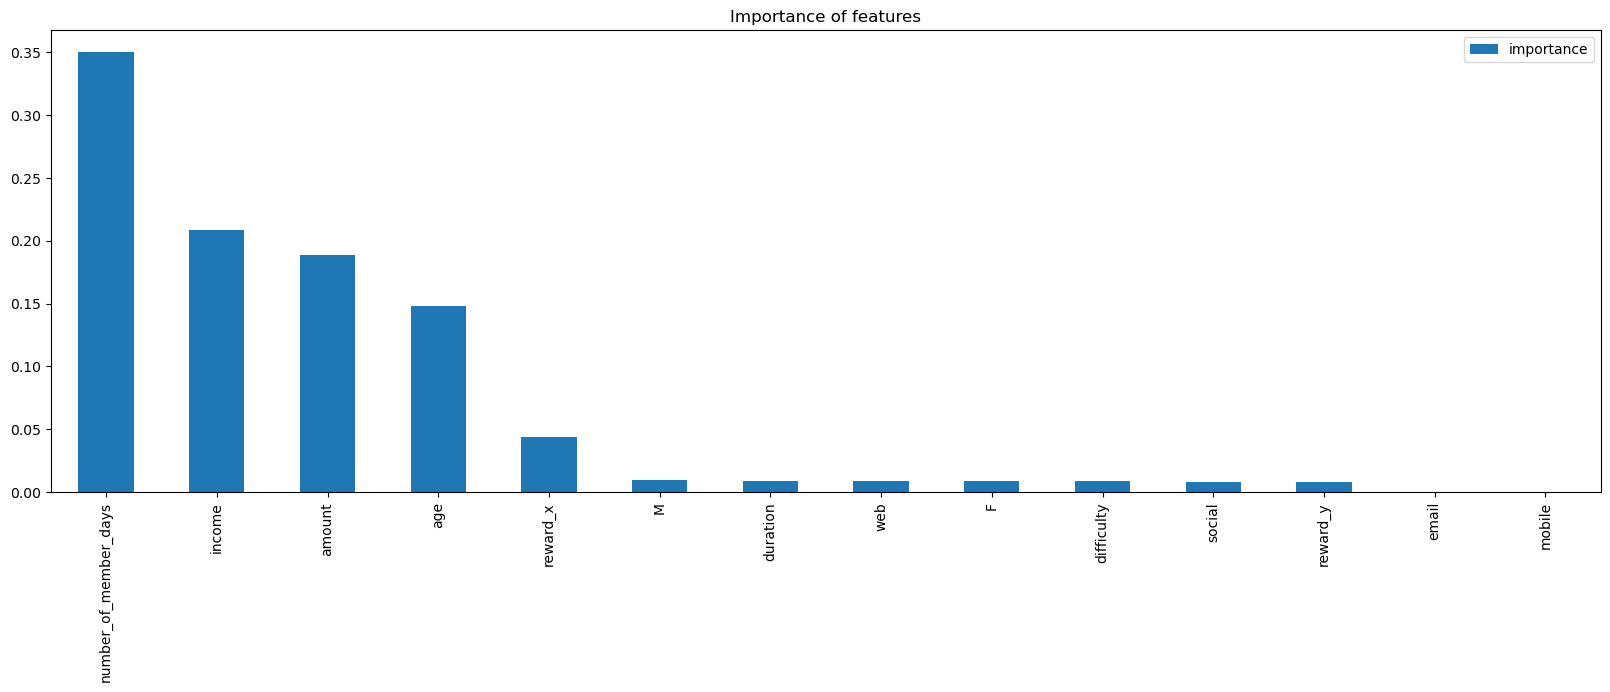

In [178]:

# Initialize the model with the parameters obtained from the grid search

rf_model2 = RandomForestClassifier(random_state=1, max_depth= 10, max_features= 'sqrt',min_samples_split= 16, n_estimators=25, min_samples_leaf=2)


# Compute the results by fitting the data on the model pipeline for the random forest model 
results_rf2 = model_pipeline(rf_model2, bogo, drop_col)


# Find out which features are important
feature_importances2 = pd.DataFrame(rf_model2.feature_importances_,
                                   index = results_rf2['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances2.plot.bar()
plt.title('Importance of features')
plt.show()

## Optimized discount ML model

In [180]:
drop_col = ['person','new_offer_id','offer_type', 'event', 'offer completed', 'time'] # These are the columns
# we would like to drop from the features set

# run Grid Search : this step takes quite some time to implement. You could comment it out and directly 
# use the optimized parameters in the next cell.
# grid_search_opt(discount, drop_col)

Train accuracy:0.813
Test accuracy:0.784
MSE_train: 0.187
MSE_test: 0.216
              precision    recall  f1-score   support

           0     0.5385    0.0837    0.1449       418
           1     0.7922    0.9799    0.8761      1490

    accuracy                         0.7835      1908
   macro avg     0.6653    0.5318    0.5105      1908
weighted avg     0.7366    0.7835    0.7159      1908



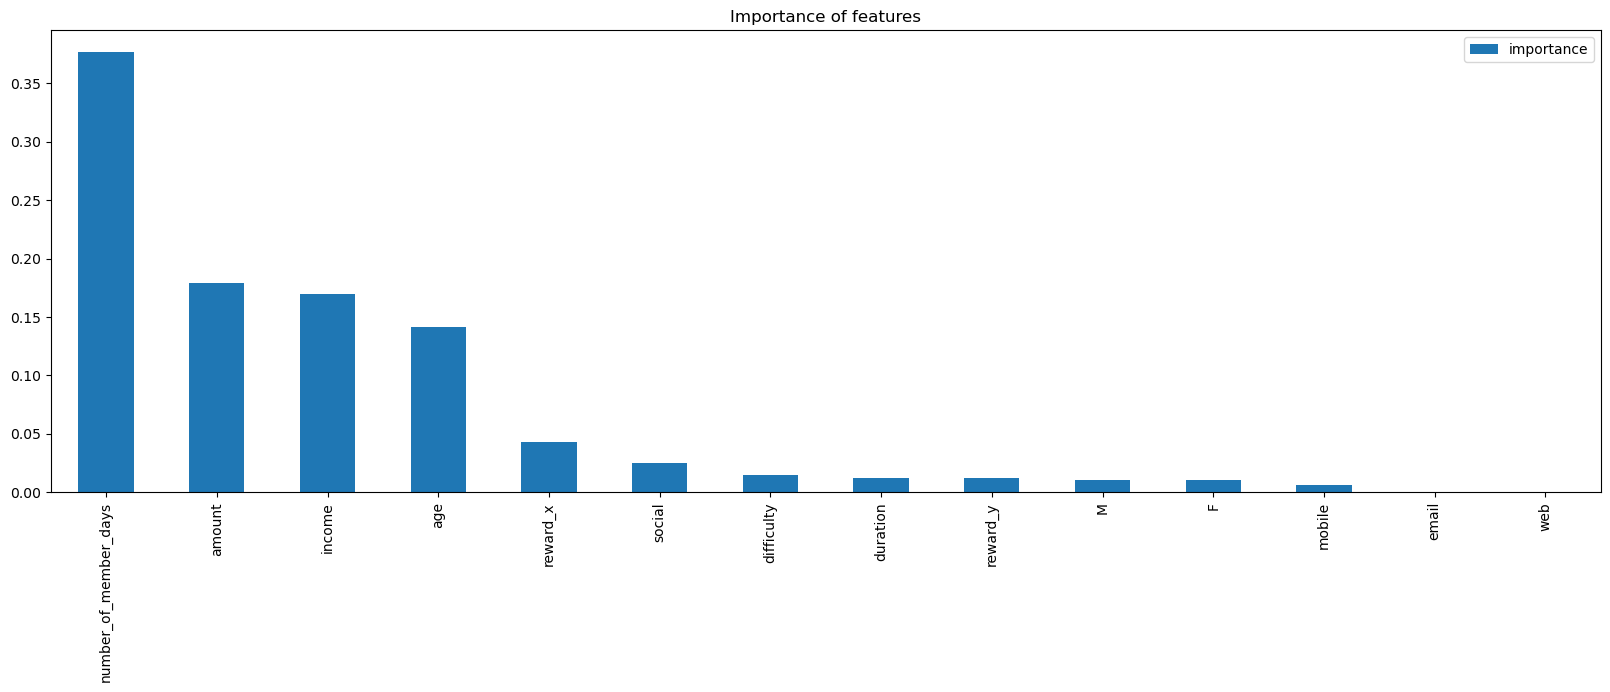

In [182]:

# Initialize the model with the parameters obtained from the grid search

rf_model2 = RandomForestClassifier(random_state=1, max_depth= 10, max_features= 'sqrt', min_samples_split= 20, n_estimators=30, min_samples_leaf=2)


# Compute the results by fitting the data on the model pipeline for the random forest model 
results_rf2 = model_pipeline(rf_model2, discount, drop_col)


# Find out which features are important
feature_importances2 = pd.DataFrame(rf_model2.feature_importances_,
                                   index = results_rf2['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances2.plot.bar()
plt.title('Importance of features')
plt.show()

## Optimized informational ML model

In [185]:
drop_col = ['person','new_offer_id','offer_type', 'event', 'offer completed', 'time'] # These are the columns
# we would like to drop from the features set

# run Grid Search : this step takes quite some time to implement. You could comment it out and directly 
# use the optimized parameters in the next cell.
# grid_search_opt(informational, drop_col)

Train accuracy:0.725
Test accuracy:0.694
MSE_train: 0.275
MSE_test: 0.306
              precision    recall  f1-score   support

           0     0.3750    0.0108    0.0210       278
           1     0.6968    0.9922    0.8187       637

    accuracy                         0.6940       915
   macro avg     0.5359    0.5015    0.4198       915
weighted avg     0.5990    0.6940    0.5763       915



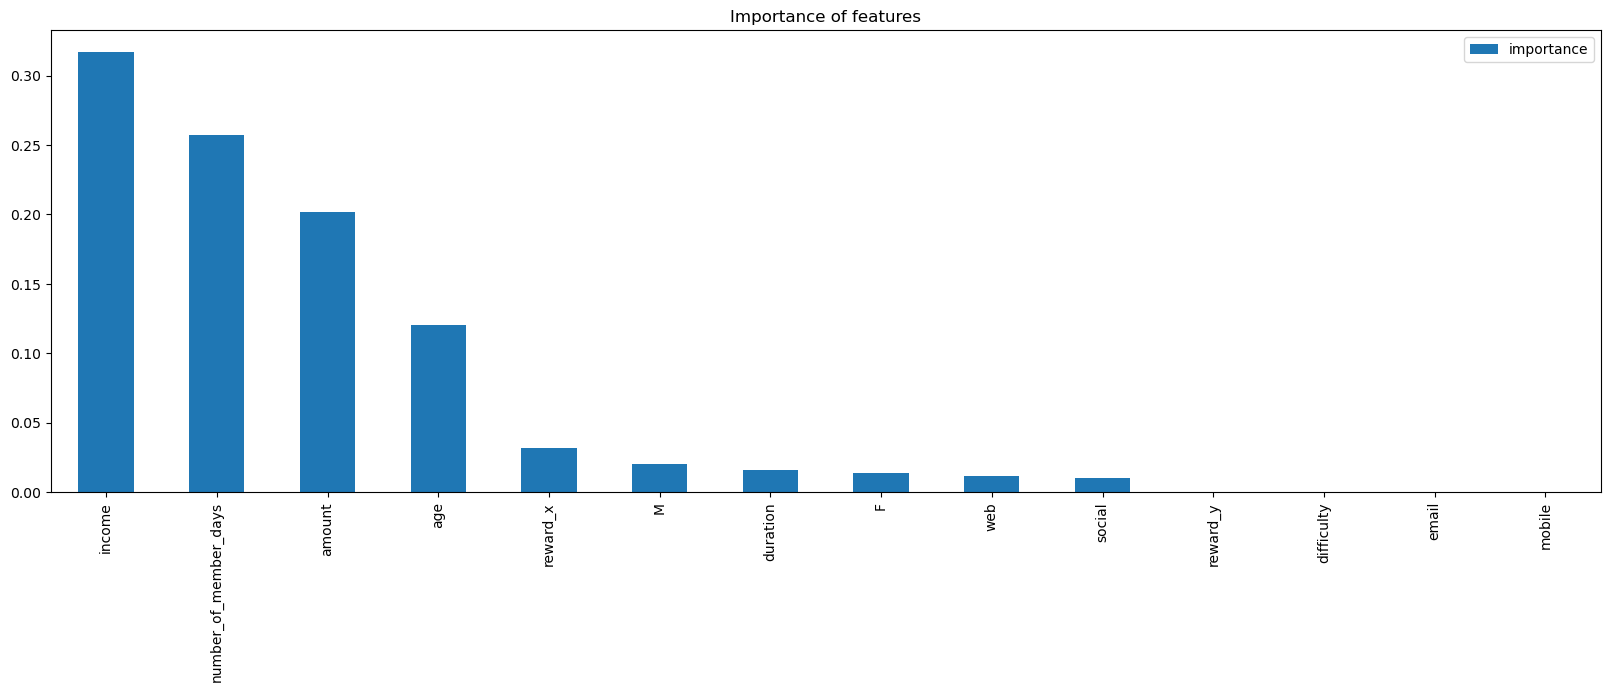

In [187]:

# Initialize the model with the parameters obtained from the grid search

rf_model2 = RandomForestClassifier(random_state=1, max_depth= 5, max_features= 'sqrt', min_samples_split= 2, n_estimators=35, min_samples_leaf=16)


# Compute the results by fitting the data on the model pipeline for the random forest model 
results_rf2 = model_pipeline(rf_model2, informational, drop_col)


# Find out which features are important
feature_importances2 = pd.DataFrame(rf_model2.feature_importances_,
                                   index = results_rf2['cols_to_use'],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances2.plot.bar()
plt.title('Importance of features')
plt.show()

# Analyses of the feature importances

The training and the test accuracies and F1 scores in all the three datasets seem reasonable (and the decision tree and random forest models perform equally well).

In all the three datasets, it turns out that the number of membership days is a very important feature. Presumably, the longer one is a member, the more likely they will respond to the offer they receive. 

Income seems to be the most important factor for an informational offer however. 

Amount, age and income are, in general, other important factors. Gender and social channel used to communicate the offers seem to matter less. This aligns with our previous analysis of the demographics of effective offers (where income, age seemed to show differences; even gender was important but slightly less so).

Optimizing the parameters of the model using grid search algorithms improve the accuracy and F1 score but not by a lot.


## Conclusion

The project started out with trying to answer the following questions : What features influence the effectiveness of a Starbucks offer? And what demographics best respond to the offers?

#### Main challenges :

1. Defining an effective offer and merging the three datasets together with the final column of the effective offer was the most challenging part of this problem. 

2. Cleaning up the data and considering what to do with the NaNs in the dataset; and the rows corresponding to the gender 'O' has also been challenging.

3. Finally, building new effective features for the machine learning models was an important yet challenging part of the problem.


#### Overall results:



Our analyses suggests that the number of membership days plays a very part in predicting whether an offer is effective or not.

For all three kinds of offers, membership time, income and age seem very important. Gender and social channel used to communicate the offers seem to matter less. Overall, for the demographics, it seems like low-income young men are more likely to take on the offers.



# Further Scope for the project 

Due to time constraints, we could not explore the project to its fullest. However, there is a lot of room for further improvement and analyses.

1. The project could be extended further by considering other cases where the offer was not taken up.

2. We could have tried to engineer more features for the machine learning models as well. 

3. We could have tried other forms of machine learning models. 

4. We could also have made a regression model on the time it took a customer to accept an offer and find out what features were relevant to this regression model. 

5. Furthermore, the models could be fine tuned even further to get higher prediction accuracies. 


